<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_1D_perparticle_distdistshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 8.0 MB/s 


In [88]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


# 1D gaussian signal with shift
* gaussian pixelated noise $\sigma_{noise}$
* prior of shift is gaussian with fixed and known params  $\mu_{shift}, \sigma_{shift}$

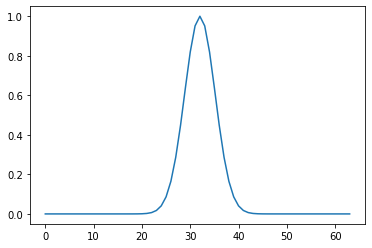

In [193]:
num_pix = 64
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal2 = 10
clean_signal = torch.exp(-domain**2/(2*sigma_signal2))
pd.Series(clean_signal).plot()

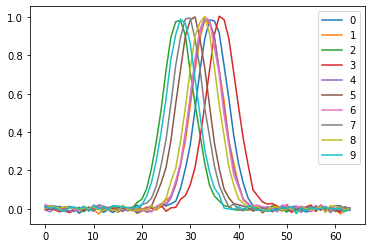

In [216]:
# synthetic data. normally, these would come from actual measurements and we would not know shift. h
# ere we have access to the ground truth
sigma_noise = 0.01
num_particles = 100
data = torch.empty((num_particles,num_pix))
for i in range(num_particles):
  shift = dist.Normal(0,2).sample()
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal2))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()
pd.DataFrame(data[:10].numpy().T).plot()

In [217]:
# def model(data):
#   batch_size=1
#   shift = pyro.sample('shift',dist.Normal(0,2))
#   clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
#   for i in pyro.plate("data", size=len(data), subsample_size=batch_size):
#     pyro.sample("particle_1d_%d"%i, dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[i])

def model(data):
  pyro.sample('shift_mean',dist.Normal(0,.01))
  pyro.sample('shift_std',dist.Normal(2,.01))
  for i in pyro.plate('data',len(data)):
    shift = pyro.sample('shift_%i'%i,dist.Normal(0,2)) # TODO: what if we don't know 0,2 here, we just use best guess
    clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal2))
    for j in pyro.plate("measurement_%i"%i, num_pix):
      pyro.sample("particle_1d_%i_%i"%(i,j), dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[i])

In [218]:
def guide(data): # the proposal distribution
  """
  learn the parameters of our modelled encoding of the signal (a 1D atom)
  hard coded fixed noise of 0.1
  """
  shift_mean_mean = pyro.param("shift_mean_mean", torch.tensor(0.))
  shift_mean_std = pyro.param("shift_mean_std", torch.tensor(0.01), constraint=torch.distributions.constraints.positive)
  shift_std_mean = pyro.param("shift_std_mean", torch.tensor(2.))
  shift_std_std = pyro.param("shift_std_std", torch.tensor(0.01), constraint=torch.distributions.constraints.positive)
  shift_mean = pyro.sample("shift_mean",dist.Normal(shift_mean_mean,shift_mean_std))
  shift_std = pyro.sample("shift_std",dist.Normal(shift_std_mean,shift_std_std))
  for i in range(len(data)):
    shift = pyro.sample('shift_%i'%i,dist.Normal(shift_mean,shift_std))

In [219]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, # takes in guess, returns sample of weight
                     guide=guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.03}), # the optimizer
                     loss=pyro.infer.Trace_ELBO())

0
1
2
shift_mean_mean =  0.05072556063532829
shift_mean_std =  0.01030421257019043
shift_std_mean =  1.910115122795105
shift_std_std =  0.009484129957854748


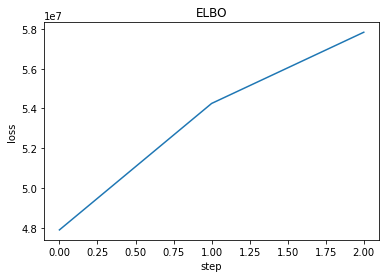

In [220]:
losses, shift_mean_mean, shift_mean_std, shift_std_mean, shift_std_std  = [], [], [], [], []
num_epochs = 3
for ep in range(num_epochs):
    if ep < 10 or (ep%(num_epochs//10) == 0): print(ep)
    losses.append(svi.step(data[:]))
    shift_mean_mean.append(pyro.param("shift_mean_mean").item())
    shift_mean_std.append(pyro.param("shift_mean_std").item())
    shift_std_mean.append(pyro.param("shift_std_mean").item())
    shift_std_std.append(pyro.param("shift_std_std").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('shift_mean_mean = ',pyro.param("shift_mean_mean").item())
print('shift_mean_std = ',pyro.param("shift_mean_std").item())
print('shift_std_mean = ',pyro.param("shift_std_mean").item())
print('shift_std_std = ',pyro.param("shift_std_std").item())

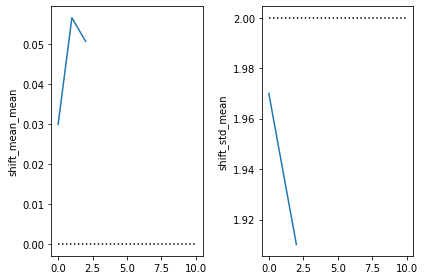

In [221]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[0,0], 'k:')
plt.plot(shift_mean_mean)
plt.ylabel('shift_mean_mean')
plt.subplot(1,2,2)
plt.ylabel('shift_std_mean')
plt.plot([0,num_steps],[2,2], 'k:')
plt.plot(shift_std_mean)
plt.tight_layout() 
# std | num_particles | sigma_noise
# 0.25 | 100 | 0.1
# 0.25 | 1000 | 0.1
# 0.25 | 1000 | 0.4